<br>

## Skip-Connection model 추가

<br>

__Skip-Connection model 구현__ <br>

이전 스텝에서 우리는 Conv1D 기반의 간단한 분류 모델을 구현해서 학습 및 테스트를 진행해 보았습니다. 간단한 모델임에도 정확도가 나쁘지 않았을 것입니다. <br><br>

하지만 여러분들은 이미지처리 모델을 다루면서 ResNet 등 skip-connection을 활용한 모델들이 훨씬 안정적으로 높은 성능을 낼 수 있음을 배워왔을 것입니다. 그렇다면 이번 음성처리 모델에 적용해도 비슷한 개선 효과를 낼 수 있지 않을까요? <br><br>

기존의 모델을 skip-connection이 추가된 모델로 변경해 학습을 진행해보겠습니다.<br><br>

<img src="/home/ssac29/Desktop/Week04_01_Explorations_speech_recognition/skip-connection.max-800x600.png"> <br>

그림에서 보듯이 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현됨을 확인할 수 있습니다. Concat을 이용한 방식으로 구현하면 됩니다.

tf.concat([#layer output tensor, layer output tensor#], axis=#)

우리가 사용하는 데이터가 1차원 audio 데이터이기 때문에 1차원 데이터를 처리하는 모델을 구성해보겠습니다.
모델 구성만 달라졌을 뿐, 그 외 Task구성이나 데이터셋 구성, 훈련 과정은 동일합니다.

<br>

<br>

### 음성데이터 추가

<br>

In [1]:
"""
데이터 준비
$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz
"""

"""
1000 Hz 신호를 저장한 wav 파일입니다.
Sample rate 는 48000 Hz, 즉 1초 재생하는데 필요한 Sample 수는 48000개입니다.
모든 샘플은 -1 ~ 1 사이의 정해진 bits per sample의 값으로 표현됩니다.
"""

import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [3]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  6186
Wave data shape :  (8000,)
label :  ['left']


<br>

### Label data 처리

<br>

In [4]:
"""
단어의 정답은 Text 형태로 이뤄져있습니다.
학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어줘야 합니다.
"""

target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)


# Text 데이터를 index 데이터로 변환 (key:value 쌍으로)
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [5]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

<br>

### Train / Test 데이터셋 분리

<br>

In [6]:
"""
sklearn으로 train셋과 test셋 분리
"""

from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 5.4731366e-04  7.5171079e-04  1.0559810e-03 ...  2.1606358e-03
   1.7610751e-03  1.8236063e-03]
 [ 1.4966820e-02  2.2673117e-02  2.0714819e-02 ... -4.2262454e-02
  -3.8528603e-02 -4.1409113e-02]
 [-2.5055409e-05 -6.8646710e-05 -1.1580982e-05 ...  4.0040519e-05
   5.9828639e-05  6.5188076e-05]
 ...
 [ 3.2764883e-03  4.7400338e-03  5.2481779e-04 ...  2.6043120e-03
   2.0563852e-03 -2.3497529e-03]
 [ 4.0450101e-03  6.2486054e-03  2.4253535e-03 ...  5.5210264e-03
   2.3371039e-03  3.5357790e-04]
 [ 3.3020594e-03  5.2962475e-03  3.3845913e-04 ...  2.3406672e-03
   1.3487448e-03 -2.1896281e-03]]
✅


In [7]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


<br>

### 하이퍼파라미터 세팅

<br>

In [8]:
"""
학습을 위한 하이퍼파라미터 설정
모델 체크포인트 저장을 위한 경로 설정
( 이후에 모델 체크포인트 Callback 함수를 설정하거나 모델을 불러올 때 사용 )
"""

batch_size = 32                     # batch_size=32, max_epochs=10으로 세팅한 경우라면 30분 가량 소요
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

checkpoint_dir

'/home/ssac29/aiffel/speech_recognition/models/wav'

<br>

### 데이터 전처리

<br>

tf.data.Dataset을 이용해서 데이터셋을 구성하겠습니다. Tensorflow에 포함된 이 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해 줍니다. 자주 사용하게 되니 사용법을 잘 익혀 둡시다.

tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.

map 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할을 합니다. 첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정합니다.
map 함수는 중첩해서 사용이 가능합니다.

<br>

In [9]:
"""
데이터 전처리 함수 작성 ( map 함수에 넘겨주기 위해 )
"""

def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [10]:
"""
tf.data.Dataset 함수를 구성
"""


import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
                                            # batch()는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


<br>

### Model construction &ensp; : Skip-Connection 모델 구현

<br>

In [11]:
"""
Model
Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델을 구성
Conv1D layer를 이용해서 모델을 구성
Conv, batch norm, dropout, dense layer 등을 이용해 모델을 구성
tf.concat을 이용하여 skid-connection layer를 추가한 새로운 모델 생성
"""

from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))      # input data로 1차원 binary 데이터의 (sp, 1)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 8000, 32)     320         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8000, 32)     9248        conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 4000, 32)     0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


<br>

Callback 구성

<br>

In [13]:
"""
Model Checkpoint callback은 
모델을 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있습니다.
현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있습니다.
"""

# 하이퍼파라미터 세팅의 checkpoint_dir 사용

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


<br>

### Training

<br>

In [14]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.2294 - accuracy: 0.6056
Epoch 00001: val_loss improved from inf to 0.83736, saving model to /home/ssac29/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 196s 138ms/step - loss: 1.2294 - accuracy: 0.6056 - val_loss: 0.8374 - val_accuracy: 0.7456
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.8111
Epoch 00002: val_loss improved from 0.83736 to 0.56508, saving model to /home/ssac29/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 198s 139ms/step - loss: 0.6457 - accuracy: 0.8111 - val_loss: 0.5651 - val_accuracy: 0.8291
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.9098
Epoch 00003: val_loss improved from 0.56508 to 0.44446, saving model to /home/ssac29/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 197s 139ms

<br>

### 학습결과 plot

<br>

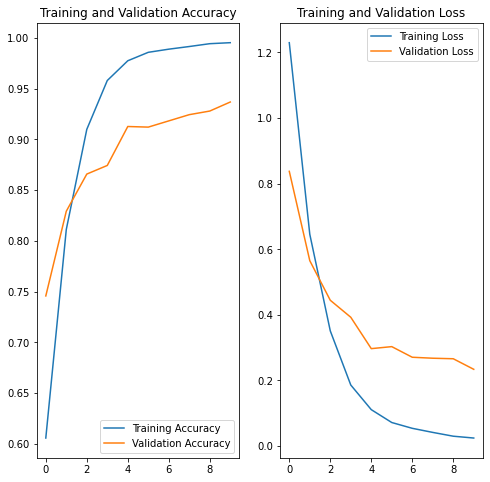

✅


In [15]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

<br>

### 모델 평가 Evaluation

<br>

In [17]:
"""
Test dataset을 이용해서 모델의 성능을 평가합니다.
"""

# 실습삼아 checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트
model_wav_skip.load_weights(checkpoint_dir)

# Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 12s 76ms/step - loss: 0.2339 - accuracy: 0.9368
loss value: 0.234
accuracy value: 93.6784%
